In [2]:
#To install wandb package ,which is helpful in generating plots and report.
!pip install wandb

     |████████████████████████████████| 1.7 MB 4.2 MB/s 
     |████████████████████████████████| 181 kB 54.9 MB/s 
     |████████████████████████████████| 144 kB 54.8 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=17b410f890a19edcddd8797b48a3250f0a8209cb901d627b6c48cd698d5f0172
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [3]:
# Essentials
import numpy as np
import tensorflow
from tensorflow import keras
from keras import regularizers
from keras.models import Sequential
from keras.utils import np_utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten, Conv2D, BatchNormalization, Dropout, MaxPooling2D, Activation
import wandb
from wandb.keras import WandbCallback
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import gridspec

import random
import imageio
import os
import cv2
import glob
# random.seed(42)

### Download INaturalist Dataset from github repo

In [4]:
# Load Dataset
!git clone https://github.com/ashwanth10/INaturalist_Dataset.git

Cloning into 'INaturalist_Dataset'...
remote: Enumerating objects: 12030, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 12030 (delta 0), reused 2 (delta 0), pack-reused 12026
Receiving objects: 100% (12030/12030), 3.55 GiB | 14.18 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Checking out files: 100% (11999/11999), done.


## Preprocess Train & Test Data

In [5]:
# Labels for INaturalist Dataset
class_labels = {
    0: 'Amphibia',
    1: 'Animalia',
    2: 'Arachnida',
    3: 'Aves',
    4: 'Fungi',
    5: 'Insecta', 
    6: 'Mammalia', 
    7: 'Mollusca', 
    8: 'Plantae',
    9: 'Reptilia'
}

num_classes = 10
img_size = 128
directory_train = 'INaturalist_Dataset/train'
directory_test  = 'INaturalist_Dataset/val'

# Load training data
x_train = []
y_train = []
for label, name in class_labels.items():
   list_images = os.listdir(directory_train + '/' + name)
   for image_name in list_images:
       try:
          image = imageio.imread(directory_train +'/'+name+'/'+image_name)
       except: 
          continue
       if np.ndim(image) == 3:
          x_train.append(cv2.resize(image, (img_size, img_size)))
          y_train.append(label)
       else: 
          # Some images are black and white
          print(image_name)

# Load testing data
x_test = []
y_test = []
for label, name in class_labels.items():
   list_images = os.listdir(directory_test + '/' + name)
   for image_name in list_images:
       try:
          image = imageio.imread(directory_test +'/'+name+'/'+image_name)
       except: 
          continue
       if np.ndim(image) == 3:
          x_test.append(cv2.resize(image, (img_size, img_size)))
          y_test.append(label)
       else: 
          # Some images are black and white
          print(image_name)

2fad1ed3a05629c089cd530f297e27e6.jpg
d192b73b0af85824c65e91f8795d8df7.jpg
aa66b3ba5ccffdb3c41c1d3acf7dd569.jpg


In [6]:
#converting training list into numpy arrays.
x_train = np.array(x_train)
y_train = np.array(y_train)

#converting test list into numpy arrays.
x_test = np.array(x_test)
y_test = np.array(y_test)


In [7]:
# Set seed
np.random.seed(0)

In [8]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,
                                                  test_size=0.1, 
                                                  stratify=y_train,
                                                  random_state=42)

In [9]:
# normalize training data
x_train = x_train / 255
x_val = x_val / 255

#normalize testing data
x_test = x_test / 255

In [10]:
# One-hot encoding for training data
targs = np.zeros((len(y_train), 10, 1))
for i in range(len(y_train)):
    targs[i][y_train[i]][0] = 1 # preparing the target matrix 

y_train = targs

In [11]:
# One-hot encoding for validation data
targs_val = np.zeros((len(y_val), 10, 1))
for i in range(len(y_val)):
    targs_val[i][y_val[i]][0] = 1 # preparing the target matrix 

y_val = targs_val

In [12]:
# One-hot encoding for testing data
targs_test = np.zeros((len(y_test), 10, 1))
for i in range(len(y_test)):
    targs_test[i][y_test[i]][0] = 1 # preparing the target matrix 

y_test = targs_test

# Functions and some helper Functions

In [13]:
def addActivation(model, activation_name):
    if activation_name == "relu":
        model.add(Activation('relu'))
    elif activation_name == "elu":
        model.add(Activation('elu'))
    elif activation_name == "selu":
        model.add(Activation('selu'))

In [14]:
def configureBatchNormalization(model, do_batch_normalisation):
    if do_batch_normalisation:
        model.add(BatchNormalization())

In [15]:
def calculateTestAccuracy(model,x_test,y_test):
  yhat=model.predict(x_test)
  yhat_max = np.argmax(yhat, axis=1)
  y_test_max = np.argmax(y_test, axis=1)
  y_test_max = y_test_max.reshape(-1)
  accuracy= (yhat_max == y_test_max).sum()/ y_test.shape[0]
  print('accuracy: ', accuracy)

In [16]:
def train_with_params(x_train, y_train, x_val, y_val, x_test, y_test,
                      filter, kernel_size, input_shape, weight_decay, 
                      activation_name, do_batch_normalisation, neurons_in_dense,
                      dropout, num_classes, learning_rate, batch_size,
                      do_data_augmentation, manual_run=False):

    # clear session
    tensorflow.keras.backend.clear_session()

    # Define the model architecture
    model = Sequential()

    # no. of convolution layers
    NUM_OF_CONV_LAYERS = 5

    for i in range(NUM_OF_CONV_LAYERS):
        model.add(Conv2D(filters = filter[i], kernel_size = kernel_size[i],
                          padding = 'same', input_shape = input_shape, 
                          kernel_regularizer=regularizers.l2(weight_decay)))
        
        addActivation(model, activation_name)
        configureBatchNormalization(model, do_batch_normalisation)
        model.add(MaxPooling2D(pool_size=(2, 2))) 
    
    # Fully connected  layer
    model.add(Flatten())
    model.add(Dense(neurons_in_dense, activation=activation_name, kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Dropout(dropout))
    model.add(BatchNormalization())

    # Output layer
    model.add(Dense(num_classes, activation = "softmax"))

    # Define the optimizer
    optimizer = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999)
    
    model.compile(loss = "categorical_crossentropy", optimizer = optimizer, metrics=['accuracy'])

    # Data augmentation
    if do_data_augmentation:
        datagen = ImageDataGenerator(
            rotation_range=45,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False  # randomly flip images
        )
    else:
        datagen = ImageDataGenerator(rescale = 1.0)

    datagen.fit(x_train)
    
    # Call Wandb Only when initiated.
    if manual_run:
        model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs = 5,
        verbose = 1,
        validation_data= (x_val, y_val))
    else: 
        model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs = 5,
        verbose = 1,
        validation_data= (x_val, y_val),
        callbacks = [WandbCallback()])

    # Calculate accuracy of the model
    calculateTestAccuracy(model, x_test, y_test)
    model.save('/content/drive/MyDrive/Models/model.keras')
    
    return model

## WandB Config Params for the Sweeps

In [17]:
sweep_config = {
    'method': 'random', 
    'metric': {
      'name': 'accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'kernel_size':{
            'values': [[(3,3),(3,3),(3,3),(3,3),(3,3)], [(3,3),(5,5),(5,5),(7,7),(7,7)], [(7,7),(7,7),(5,5),(5,5),(3,3)], [(3,3),(5,5),(7,7),(9,9),(11,11)] ]
        },
        'weight_decay': {
            'values': [0, 0.0005, 0.005]
        },
        'dropout': {
            'values': [0, 0.2, 0.4]
        },
        'learning_rate': {
            'values': [1e-3, 1e-4]
        },
        'activation': {
            'values': ['relu', 'elu', 'selu']
        },
        'batch_norm':{
            'values': [True, False]
        },
        'filt_org':{
            'values': [[32,32,32,32,32],[32,64,64,128,128],[128,128,64,64,32],[32,64,128,256,512]]
        },
        'data_augment': {
            'values': [True, False]
        },
        'batch_size': {
            'values': [32, 64]
        },
        'num_dense':{
            'values': [64, 128, 256, 512]
        }
    }
}

In [18]:
sweep_id = wandb.sweep(sweep_config, entity="cs21m010-cs21m041", project="DL_Assignment_2")

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: a6xq1i9h
Sweep URL: https://wandb.ai/cs21m010-cs21m041/DL_Assignment_2/sweeps/a6xq1i9h


# Run WandB Sweeps

In [19]:
def train():

    # Initialize a new wandb run
    wandb.init(config=sweep_config)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config
    wandb.run.name = 'num_dense_'+ str(config.num_dense)+'_bs_'+str(config.batch_size)+'_ac_'+ config.activation
    
    # Determine input shape
    input_shape = (img_size, img_size , 3)
    
    # train_with_params(x_train, y_train, x_val, y_val, x_test, y_test,
    #                   config.filt_org, config.kernel_size, input_shape, 
    #                   config.weight_decay, config.activation, config.batch_norm, 
    #                   config.num_dense, config.dropout, num_classes, 
    #                   config.learning_rate, config.batch_size, config.data_augment)
    

In [20]:
wandb.agent(sweep_id, train, count = 1)

wandb: Agent Starting Run: 6bgv6x9d with config:
wandb: 	activation: relu
wandb: 	batch_norm: False
wandb: 	batch_size: 64
wandb: 	data_augment: True
wandb: 	dropout: 0.2
wandb: 	filt_org: [32, 64, 128, 256, 512]
wandb: 	kernel_size: [[7, 7], [7, 7], [5, 5], [5, 5], [3, 3]]
wandb: 	learning_rate: 0.0001
wandb: 	num_dense: 512
wandb: 	weight_decay: 0.005
wandb: Currently logged in as: harishpilla (use `wandb login --relogin` to force relogin)


# Get the Best Model

In [21]:
best_kernel_size = [(3,3),(3,3),(3,3),(3,3),(3,3)]
best_weight_decay = 0.005
best_dropout = 0.4
best_learning_rate = 0.0001
best_activation = 'relu'
best_batch_size = 64
best_batch_norm = False
best_filt_org = [32,64,128,256,512]
best_data_augment = True
best_num_dense = 128
input_shape = (img_size, img_size , 3)

model = train_with_params(x_train, y_train, x_val, y_val, x_test, y_test,
                      best_filt_org, best_kernel_size, input_shape, 
                      best_weight_decay, best_activation, best_batch_norm, 
                      best_num_dense, best_dropout, num_classes, 
                      best_learning_rate, best_batch_size, best_data_augment, manual_run=True)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/5
141/141 [==============================] - 54s 298ms/step - loss: 5.8690 - accuracy: 0.1693 - val_loss: 5.1972 - val_accuracy: 0.2520
Epoch 2/5
141/141 [==============================] - 40s 286ms/step - loss: 4.6525 - accuracy: 0.2128 - val_loss: 4.3594 - val_accuracy: 0.2590
Epoch 3/5
141/141 [==============================] - 41s 288ms/step - loss: 4.0086 - accuracy: 0.2360 - val_loss: 3.8325 - val_accuracy: 0.2750
Epoch 4/5
141/141 [==============================] - 40s 284ms/step - loss: 3.5925 - accuracy: 0.2520 - val_loss: 3.4020 - val_accuracy: 0.2880
Epoch 5/5
141/141 [==============================] - 40s 282ms/step - loss: 3.2994 - accuracy: 0.2649 - val_loss: 3.1338 - val_accuracy: 0.3040
accuracy:  0.3005


# Load the saved model

In [22]:
import tensorflow as tf
model = tf.keras.models.load_model('/content/drive/MyDrive/Models/model.keras')

# Visualize few sample images and plot filters

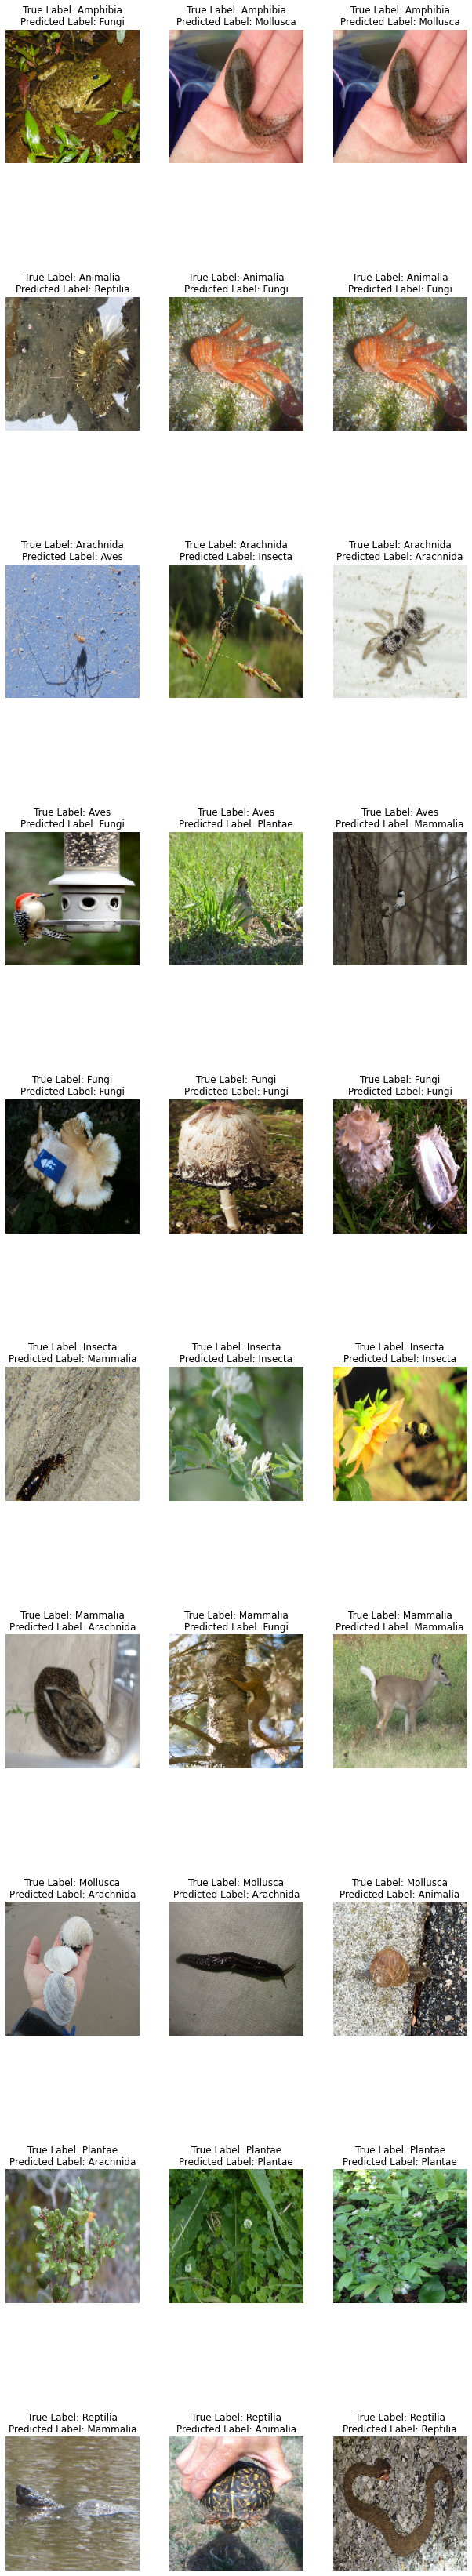

In [23]:
test_data_images = []
test_data_labels = []

# Iterate over each class_label and capture 3 images of each class
for label, name in class_labels.items():
    images_of_a_class = os.listdir(directory_test + '/' + name)

    # Capture 3 random images
    for index in range(3):
        randomIndex = random.randint(0, 199)

        # Read the image
        selected_image = imageio.imread(directory_test + '/' + name + '/' + images_of_a_class[randomIndex])

        # Consider images only if are RGB colors
        if np.ndim(selected_image) == 3:
            test_data_images.append(cv2.resize(selected_image, (img_size,img_size)))
            test_data_labels.append(class_labels[label])

# Convert the images to numpy arrays and normalize
test_data_images = np.array(test_data_images)
test_data_images = test_data_images / 255

# Plotting a small subset of classes and labels
fig = plt.figure(figsize=(60,50))

gridspec_obj = gridspec.GridSpec(10, 3, width_ratios=[1, 1, 1], wspace=0.0, hspace=1.0, top=0.95, bottom=0.05, left=0.7, right=0.845) 
k = 0
for i in range(10):
    for index in range(3):
      img_subplot = plt.subplot(gridspec_obj[i, index])
      visualized_image = test_data_images[k]
      img_subplot.imshow(visualized_image)
      true_label = test_data_labels[k]
      k += 1

      # Predict the label and show titles of both true/predicted labels
      predicted_label = model.predict(visualized_image.reshape(1,128, 128, 3))[0]
      img_subplot.set_title("True Label: {}\nPredicted Label: {}".format(true_label, class_labels[np.argmax(predicted_label)]))
      img_subplot.axis('off')

plt.show()


Layer name: conv2d, Shape: (3, 3, 3, 32)
Layer name: conv2d_1, Shape: (3, 3, 32, 64)
Layer name: conv2d_2, Shape: (3, 3, 64, 128)
Layer name: conv2d_3, Shape: (3, 3, 128, 256)
Layer name: conv2d_4, Shape: (3, 3, 256, 512)


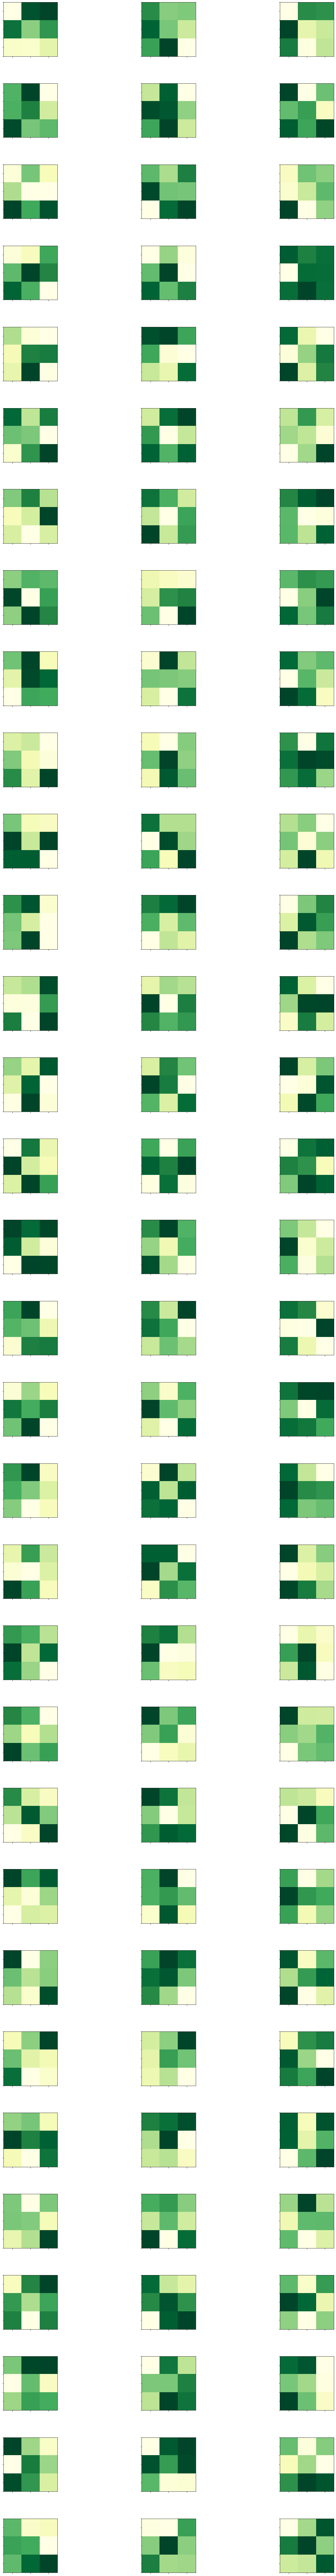

In [24]:
# Visualization of the filters
for layer in model.layers:
    if 'conv' in layer.name:
        filters, biases = layer.get_weights()
        print('Layer name: {}, Shape: {}'.format(layer.name, filters.shape))

filters, biases = model.layers[0].get_weights()

# Normalize all filter values in to range of 0 to 1 
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# Plot the filter
fig = plt.figure(figsize=(128,128))

# Create Grid
gridspec_obj_filters = gridspec.GridSpec(32, 3, width_ratios=[1, 1, 1],
                                         wspace=0.0, hspace=0.5, top=0.95,
                                         bottom=0.05, left=0.7, right=0.845) 

# plot first few filters
n_filters, ix = 32, 1

# Plot each filter 
for i in range(n_filters):
    f = filters[:, :, :, i]
    for j in range(3):
      ax = plt.subplot(gridspec_obj_filters[i,j])
      ax.imshow(f[:, :, j], cmap='YlGn')
      ax.set_xticklabels([])
      ax.set_yticklabels([])

plt.show()

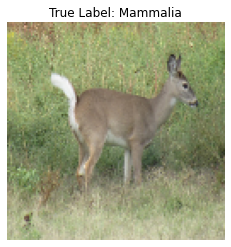

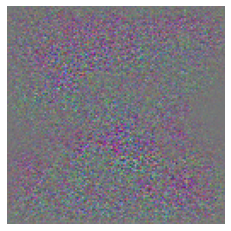

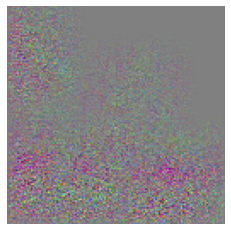

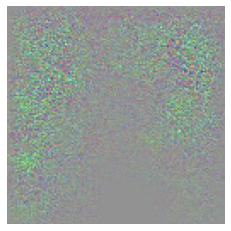

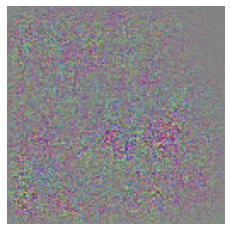

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in true_divide


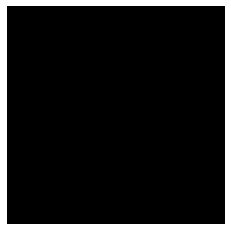

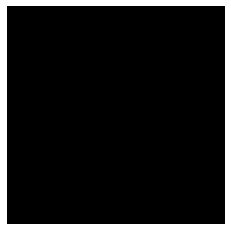

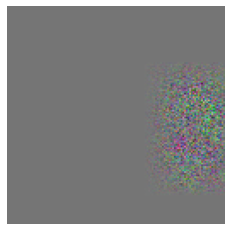

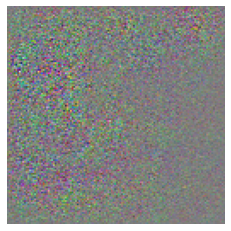

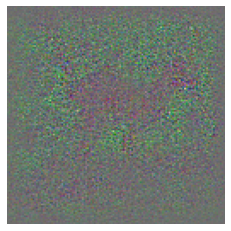

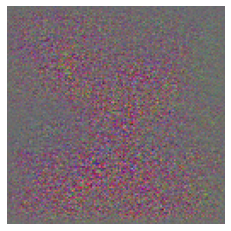

In [37]:
# run the function test() with activation 'relu' and then run the remaining portion of this code
import tensorflow as tf
from mpl_toolkits.axes_grid1 import ImageGrid

index = 20
# Load the image and pre-process
image = test_data_images[index]
image_tensor = np.expand_dims(image, axis=0)

# Display the image tensor
plt.imshow(image_tensor[0])
plt.title("True Label: " + test_data_labels[index])
plt.axis("off")
plt.show()

# Creating custom gradients
@tf.custom_gradient
def guidedRelU(x):
  def grad(dy):
    return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
  return tf.nn.relu(x), grad

# Apply guided ReLu on activation layers 
for layer in model.layers[1:]:
    if hasattr(layer, 'activation') and layer.activation == tf.keras.activations.selu:
        layer.activation = guidedRelU

gradients=[]
for i in [10,11,12,15,33,35,30,32,39,103]:
  neuron_output = tf.keras.activations.relu(model.get_layer("conv2d_4").output[:,:,:,i])
  neuron = tf.keras.models.Model(inputs = [model.inputs],outputs = [neuron_output])

  # Finding gradients of the target class score wrt feature maps
  with tf.GradientTape() as g:
    inputs = tf.cast(image_tensor, tf.float32)
    g.watch(inputs)
    outputs = neuron(inputs)

  gradients.append(g.gradient(outputs,inputs).numpy()[0])

# figure = plt.figure(figsize=(15., 15.))
# grid = ImageGrid(figure, 111,nrows_ncols=(2, 5),axes_pad=0.2)
# for axes, img in zip(grid, gradients):
#     axes.imshow(img)
#     axes.axis('off')
# plt.show()

# CONV5_layer_activation = outputs

# layer_names = ['conv2d_4']

# num_features = 10
# size = 1
# num_imag_in_row = 1
# num_cols = num_features // num_imag_in_row
# display_grid = np.ones((size * num_cols, num_imag_in_row * size))

# k = 1
# j = 1
# for col in range(num_cols): 
#   for row in range(num_imag_in_row):
#     channel_image = CONV5_layer_activation[j, k, col * num_imag_in_row + row]
#     display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
  
# scale = 1. / size
# plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
# plt.title(layer_names)
# plt.grid(False)
# plt.imshow(display_grid, aspect='auto',cmap='gray')  
# plt.show()                                         


# gridspec_obj_filters = gridspec.GridSpec(32, 3, width_ratios=[1, 1, 1],
#                                          wspace=0.0, hspace=0.5, top=0.95,
#                                          bottom=0.05, left=0.7, right=0.845) 

# plot first few filters
# n_filters, ix = 32, 1

# # Plot each filter 
# for i in range(n_filters):
#     f = filters[:, :, :, i]
#     for j in range(3):
#       ax = plt.subplot(gridspec_obj_filters[i,j])
#       ax.imshow(f[:, :, j], cmap='YlGn')
#       ax.set_xticklabels([])
#       ax.set_yticklabels([])

# plt.show()


# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
# axes[0].plot(x1, y1)
# axes[1].plot(x2, y2)
# fig.tight_layout()

# for i in range(10):
  # Guided backprop gradient visualisation
for gradient in gradients:
  grad_image = np.dstack((
              gradient[:, :, 0],
              gradient[:, :, 1],
              gradient[:, :, 2],
          ))       
  grad_image = grad_image - np.min(grad_image)
  grad_image = grad_image/grad_image.max()
  # ax = plt.subplot(gridspec_obj_filters[i,j])
  # ax.imshow(f[:, :, j], cmap='YlGn')
  imgplot = plt.imshow(grad_image,cmap='YlGn')
  plt.axis("off")
  plt.show()